In [1]:
from platform import python_version
print(python_version())

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import glob
import cv2
print(tf.__version__)

2.3.0


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
train_images = []
for i in range(0,49000):
    n= cv2.imread("./Train_UQcUa52/train/"+ str(i) + ".png")
    train_images.append(n)   
train_images = np.asarray(train_images)
train_labels = pd.read_csv("./Train_UQcUa52/train.csv", usecols=['label']).values.flatten() 
    
test_images = []
for i in range(49000,70000):
    n= cv2.imread("./Test_UQcUa52/test/"+ str(i) + ".png")
    test_images.append(n)
test_images = np.asarray(test_images)

train_images = (train_images)/ 255.0
test_images = (test_images)/ 255.0

train_images = train_images[:,:,:,0].reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images[:,:,:,0].reshape((test_images.shape[0], 28, 28, 1))

In [5]:
test_images.shape

(21000, 28, 28, 1)

In [6]:
train_images.shape

(49000, 28, 28, 1)

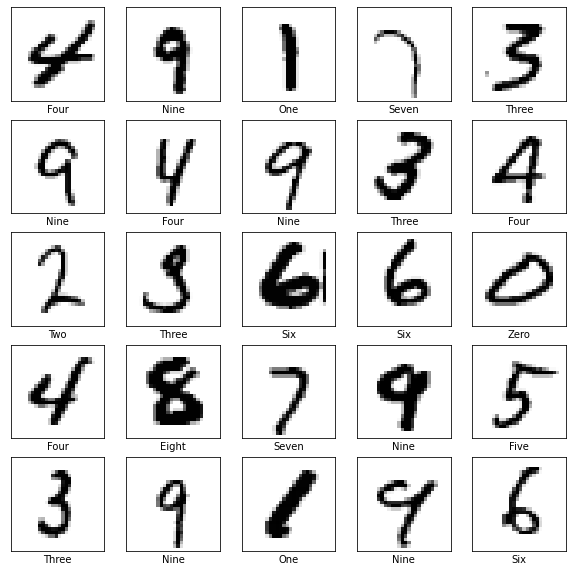

In [7]:
class_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [8]:
def squeeze_excite_block(filters,input):                      
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Reshape((1, filters))(se) 
    se = tf.keras.layers.Dense(filters//16, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    se = tf.keras.layers.multiply([input, se])
    return se


model_input = tf.keras.Input(shape=(28,28,1), name='img')
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(model_input)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = squeeze_excite_block(64,x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = squeeze_excite_block(64,x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = squeeze_excite_block(128,x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

model_output = tf.keras.layers.Dense(10)(x)

model = tf.keras.Model(model_input, model_output, name="Classifical_model")

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

Model: "Classifical_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   640         img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________

In [9]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
                                            monitor='val_accuracy', min_delta=0.0000001, 
                                            patience=10, verbose=2, mode='auto')

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor='val_loss', factor=0.1, 
                                            patience=5, min_lr=0.0001)

filepath="weights.best_v1.hdf5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(train_images, train_labels, epochs=50, validation_split=0.12, 
                    callbacks=[earlystop_callback, reduce_lr_callback, checkpoint_callback],
                    verbose=2)

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.97993, saving model to weights.best_v1.hdf5
1348/1348 - 11s - loss: 0.2109 - accuracy: 0.9359 - val_loss: 0.0620 - val_accuracy: 0.9799
Epoch 2/50

Epoch 00002: val_accuracy did not improve from 0.97993
1348/1348 - 13s - loss: 0.0790 - accuracy: 0.9785 - val_loss: 0.0953 - val_accuracy: 0.9731
Epoch 3/50

Epoch 00003: val_accuracy improved from 0.97993 to 0.98724, saving model to weights.best_v1.hdf5
1348/1348 - 12s - loss: 0.0579 - accuracy: 0.9842 - val_loss: 0.0421 - val_accuracy: 0.9872
Epoch 4/50

Epoch 00004: val_accuracy improved from 0.98724 to 0.98741, saving model to weights.best_v1.hdf5
1348/1348 - 11s - loss: 0.0501 - accuracy: 0.9863 - val_loss: 0.0449 - val_accuracy: 0.9874
Epoch 5/50

Epoch 00005: val_accuracy improved from 0.98741 to 0.99184, saving model to weights.best_v1.hdf5
1348/1348 - 12s - loss: 0.0432 - accuracy: 0.9874 - val_loss: 0.0344 - val_accuracy: 0.9918
Epoch 6/50

Epoch 00006: val_accuracy di

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


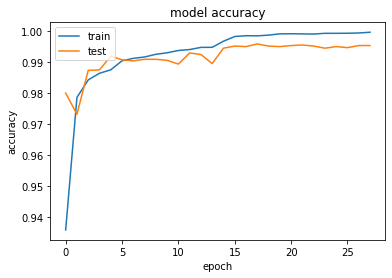

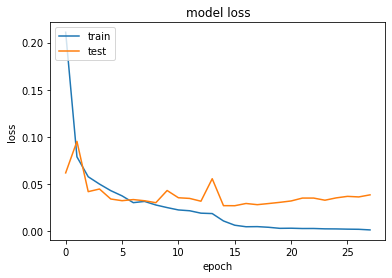

In [10]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
model.load_weights("weights.best_v1.hdf5")
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
predictions = np.argmax(model.predict(test_images), axis=-1)
predictions

array([4, 0, 9, ..., 6, 6, 2])

In [13]:
test = pd.read_csv("./Test_UQcUa52/Test_fCbTej3_0j1gHmj.csv")
test['label'] = pd.DataFrame(data=predictions.flatten())
test.to_csv("./Results/test_v2.csv", index=False)
test

,filename,label
0,49000.png,4
1,49001.png,0
2,49002.png,9
3,49003.png,7
4,49004.png,9
...,...,...
20995,69995.png,9
20996,69996.png,2
20997,69997.png,6
20998,69998.png,6
